In [15]:
import drawSvg as draw
from drawSvg.widgets import DrawingWidget
import hyperbolic.poincare.shapes as hyper  # pip3 install hyperbolicd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp



canvas_size=(800,800)
d=draw.Drawing(*canvas_size, origin='center')
traj=draw.Group()
linkage = draw.Group()
d.append(linkage)
d.append(traj)

def redraw_linkage(nodes=[], edges=[],node_radius=6,edge_width=5,d=d):
    linkage.children.clear()
    for id1,id2 in edges:
        linkage.draw(draw.Line(*nodes[id1],*nodes[id2],stroke='gray',stroke_width=edge_width))
    for x,y in nodes[1:-1]:
        linkage.draw(draw.Circle(x,y,node_radius,fill='green'))
    x,y=nodes[0]
    linkage.draw(draw.Circle(x,y,node_radius,fill='blue'))
    x,y=nodes[-1]
    linkage.draw(draw.Circle(x,y,node_radius,fill='orange'))
    
    return d

def redraw_trajectory(drive_node=[],end_node=[]):
    traj.children.clear()
    for p0,p1 in zip(drive_node[:-1],drive_node[1:]):
        traj.draw(draw.Line(*p0,*p1,stroke='blue',stroke_width=3))
    for p0,p1 in zip(end_node[:-1],end_node[1:]):
        traj.draw(draw.Line(*p0,*p1,stroke='orange',stroke_width=3))
        
        
def rotation_matrix(theta=0):
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def simulate_linkage(nodes=[],edges=[],lengths=[]):
    for i in range(0,len(edges),2):
        e02,e12=edges[[i,i+1],:]
        l02,l12=lengths[[i,i+1]]
        p0,p1=nodes[[e02[0],e12[0]],:]
        if np.linalg.norm(p1-p0)>l02+l12:
            p0=p1-(l02+l12)*(p1-p0)/np.linalg.norm(p1-p0)
            nodes[e02[0],:]=p0
        v01=(p1-p0)/np.linalg.norm(p1-p0)
        l01=np.linalg.norm(p1-p0)
        phi=np.arccos(max(-1,min(1,(l01**2+l02**2-l12**2)/(2*l01*l02))))
        p2=rotation_matrix(phi)@v01*l02+p0
        nodes[e02[1],:]=p2


In [16]:
nodes=np.array([(100,100),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
edges=np.array([(0,2),(1,2),(2,3),(1,3),(1,4),(0,4),(3,5),(4,5),(5,6),(4,6)])
lengths=np.array([100,100,100,100,100,150,100,100,150,100])
drive_node=[]
end_node=[]
# Create interactive widget and register mouse events
d = redraw_linkage(nodes, edges, lengths)
widget = DrawingWidget(d)
@widget.mousedown
def mousedown(widget, x, y, info):
    drive_node.append([*nodes[0]])
    if len(drive_node)>1:
        for i in range(0,10):
            nodes[0,:]=(1-i/10.0)*np.asarray(drive_node[-2])+(i/10.0)*np.asarray(drive_node[-1])
            simulate_linkage(nodes,edges,lengths)
            end_node.append([*nodes[-1]])
        nodes[0,:]=drive_node[-1]
    else:
        end_node.append([*nodes[-1]])
    #redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes,edges,d)
    widget.refresh()

@widget.mousemove
def mousemove(widget, x, y, info):
    nodes[0]=(x,y)
    simulate_linkage(nodes,edges,lengths)
    #redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes,edges,d)
    widget.refresh()

widget

DrawingWidget()

In [21]:
# TODO add gravity
node_mass = 5.1
motor_driving_force = 50 #N 

# get initial positions from kinematic simulation
y0 = np.concatenate((np.array(nodes).flatten(), np.zeros(len(nodes)*2)))

def model(t, y, p=()):
    def get_constraint_for_edge(nodes, edge):
        start_node = edge[0]
        end_node = edge[1]
        
        start_node_pos = nodes[start_node]
        end_node_pos = nodes[end_node]

        edge_vector = (end_node_pos - start_node_pos) / np.linalg.norm(end_node_pos - start_node_pos)
        
        result = np.zeros(len(nodes)*2)
        result[start_node*2:start_node*2+2] = edge_vector[0], edge_vector[1]
        result[end_node*2:end_node*2+2] = -edge_vector[0], -edge_vector[1]
        return result
    
    def get_actuator_rows():
        # calculate row that results from the motor
        result = np.zeros((2, len(nodes)*2))
        result[0, 0] = 1
        result[1, 1] = 1
        return result
    
    def get_actuator_force():
        radius = 5.0
        current_motor_endeffector_pos = y[0:2]
        motor_center = y0[0:2] - np.array([0.0, -radius])
        vector_from_center_to_endeffector = current_motor_endeffector_pos - motor_center
        
        # get tangent on circle around center to get the force vector
        force_vector_direction = np.array([-vector_from_center_to_endeffector[1], vector_from_center_to_endeffector[0]])
        
        v = np.linalg.norm(y[len(nodes)*2:len(nodes)*2+2])
        f_centripital = - v**2 / radius
        
        # normalize
        force_vector_direction = force_vector_direction / np.linalg.norm(force_vector_direction)
        return force_vector_direction * motor_driving_force + vector_from_center_to_endeffector/radius * f_centripital
    
    def get_stationary_rows():
        # calculate row that results from the motor
        result = np.zeros((2, len(nodes)*2))
        result[0, 2] = 1
        result[1, 3] = 1
        return result

    # calculate the forces for every node based on static solution
    node_positions = np.array([[y0[i*2], y0[i*2+1]] for i in range(len(nodes))])
    simulate_linkage(node_positions, edges, lengths)
    
    edge_constraints = np.array([get_constraint_for_edge(node_positions, edge) for edge in edges])
    force_matrix = np.concatenate((edge_constraints, get_actuator_rows(), get_stationary_rows()))
    
    equilibrium = np.concatenate((np.zeros(len(edges)),  get_actuator_force(), [0, 0]))
    force_vectors = np.linalg.solve(force_matrix, equilibrium)

    accelerations = force_vectors / node_mass
    
    return np.concatenate((y[len(nodes)*2:], accelerations))
    

simulate_linkage(nodes, edges, lengths)
fps = 30
time_span = (0.0, 20.0)
evaluate_at = np.linspace(time_span[0],time_span[1], int((time_span[1] - time_span[0])*fps))

# solve ODEs
result = solve_ivp(model, time_span, y0, method='RK45', rtol=1e-8, t_eval=evaluate_at)
result

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 13970
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.03338898,  0.06677796,  0.10016694,  0.13355593,
        0.16694491,  0.20033389,  0.23372287,  0.26711185,  0.30050083,
        0.33388982,  0.3672788 ,  0.40066778,  0.43405676,  0.46744574,
        0.50083472,  0.53422371,  0.56761269,  0.60100167,  0.63439065,
        0.66777963,  0.70116861,  0.7345576 ,  0.76794658,  0.80133556,
        0.83472454,  0.86811352,  0.9015025 ,  0.93489149,  0.96828047,
        1.00166945,  1.03505843,  1.06844741,  1.10183639,  1.13522538,
        1.16861436,  1.20200334,  1.23539232,  1.2687813 ,  1.30217028,
        1.33555927,  1.36894825,  1.40233723,  1.43572621,  1.46911519,
        1.50250417,  1.53589316,  1.56928214,  1.60267112,  1.6360601 ,
        1.66944908,  1.70283806,  1.73622705,  1.76961603,  1.80300501,
        1.83639399,  1.8697

Text(0.5, 1.0, 'solve_ivp')

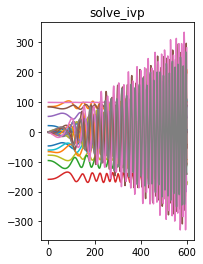

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 2)
ax.plot(result.y[:, :].T)
ax.set_title("solve_ivp")

In [19]:
from drawSvg.widgets import AsyncAnimation

widget2 = AsyncAnimation(fps=fps)
widget2

AsyncAnimation(frame_delay=33)

In [20]:
import copy
anim_nodes = copy.deepcopy(nodes) 
@widget2.set_draw_frame  # Animation above is automatically updated
def draw_frame(t=0):
    for node_idx in range(len(nodes)):
        anim_nodes[node_idx] = result.y[node_idx*2:node_idx*2+2, int((t)*fps%300)]
        
    redraw_linkage(anim_nodes,edges,d)
    return d